In [12]:
using NamedTrajectories
using CairoMakie
using JLD2
using Latexify
using LaTeXStrings

In [2]:
iso_to_ket(ψ̃::AbstractVector{Float64}) = ψ̃[1:div(length(ψ̃), 2)] + im * ψ̃[(div(length(ψ̃), 2) + 1):end]

iso_to_ket (generic function with 1 method)

In [3]:
function populations(
    ψ̃::AbstractVector{Float64};
    components=1:div(length(ψ̃), 2)
)
    ψ = iso_to_ket(ψ̃)
    return abs2.(ψ[components])
end

populations (generic function with 1 method)

In [4]:
traj = load("../data/multimode/g0_to_g1.jld2")["Ẑ"];

In [5]:
traj.controls_names

(:dda,)

In [58]:
a = 2
ls = [latexstring("ψ̃", "_$i") for i in 1:a]
ls[1]

L"$ψ̃_1$"

In [57]:
latexify("ψ̃")

L"$ψ̃$"

In [157]:
function plot_components(
    traj::NamedTrajectory,
    comps::Union{Symbol, Vector{Symbol}, Tuple{Vararg{Symbol}}} =
        [key for key in keys(traj.components) if key != :states && key != :controls];

    # data keyword arguments 
    transformations::Dict{Symbol, <:Union{Function, Vector{Function}}} = 
        Dict{Symbol, Union{Function, Vector{Function}}}(),

    # style keyword arguments
    res::Tuple{Int, Int}=(1200, 800),
    titlesize::Int=25,
    series_color::Symbol=:glasbey_bw_minc_20_n256,
    ignored_labels::Union{Symbol, Vector{Symbol}, Tuple{Vararg{Symbol}}} = 
        Symbol[]
)
    # convert single symbol to vector: comps
    if comps isa Symbol
        comps = [comps]
    end

    # convert single symbol to iterable: ignored labels
    if ignored_labels isa Symbol
        ignored_labels = [ignored_labels]
    end

    @assert all([key ∈ keys(traj.components) for key ∈ comps])
    @assert all([key ∈ keys(traj.components) for key ∈ keys(transformations)])

    # create figure
    fig = Figure(resolution=res)

    # initialize axis count
    ax_count = 0

    # plot transformed components
    for (key, f) in transformations
        if f isa Vector
            for (j, fⱼ) in enumerate(f) 

                # data matrix for key componenent of trajectory
                data = traj[key]

                # apply transformation fⱼ to each column of data
                transformed_data = mapslices(fⱼ, data; dims=1)

                # create axis for transformed data
                ax = Axis(
                    fig[ax_count + 1, 1]; 
                    title=latexstring(key, "(t)", "\\text{ transformation } $j"), 
                    titlesize=titlesize,
                    xlabel=L"t"
                )

                # plot transformed data
                srs = series!(
                    ax, 
                    times(traj), 
                    transformed_data; 
                    color=series_color, 
                    markersize=5,
                    labels=[latexstring(key, "_{$i}") for i = 1:size(transformed_data, 2)]
                )

                # create legend
                Legend(fig[ax_count + 1, 2], ax)
               
                # increment axis count
                ax_count += 1
            end
        else

            # data matrix for key componenent of trajectory
            data = traj[key]

            # apply transformation f to each column of data
            transformed_data = mapslices(f, data; dims=1)

            # create axis for transformed data
            ax = Axis(
                fig[ax_count + 1, :]; 
                title=latexstring(key, "(t)", "\\text{ transformation } $j"),
                titlesize=titlesize,
                xlabel=L"t"
            )

            # plot transformed data
            series!(
                ax, 
                times(traj), 
                transformed_data; 
                color=series_color, 
                markersize=5
            )

            # increment axis count
            ax_count += 1
        end
    end

    # plot normal components
    for key in comps 

        # data matrix for key componenent of trajectory
        data = traj[key]

        # create axis for data
        ax = Axis(
            fig[ax_count + 1, 1]; 
            title=latexstring(key, "(t)"), 
            titlesize=titlesize,
            xlabel=L"t"
        )

        # create labels if key is not in ignored_labels
        if key ∈ ignored_labels
            labels = nothing
        else
            labels = [latexstring(key, "_{$i}") for i = 1:size(data, 2)]
        end

        # plot data
        series!(
            ax, 
            times(traj), 
            data; 
            color=series_color, 
            markersize=5,
            labels=labels
        )

        # create legend
        if key ∉ ignored_labels  
            Legend(fig[ax_count + 1, 2], ax) 
        end

        # increment axis count
        ax_count += 1
    end

    fig
end

plot_components (generic function with 2 methods)

In [164]:
fig = plot_components(traj, :ψ̃; ignored_labels=:ψ̃)
save_path = "plots/test.png"
mkdir(dirname(save_path))
save(save_path, fig)

CairoMakie.Screen{IMAGE}


In [159]:
ketdim = traj.dims.ψ̃ ÷ 2

transformations = Dict(
    :ψ̃ => [
        ψ̃ -> populations(ψ̃; components=[1,2]),
        ψ̃ -> populations(ψ̃; components=[ketdim ÷ 3, ketdim ÷ 3 * 2, ketdim]),
        ψ̃ -> populations(ψ̃; components=2 * (ketdim ÷ 3):ketdim)
    ], 
);

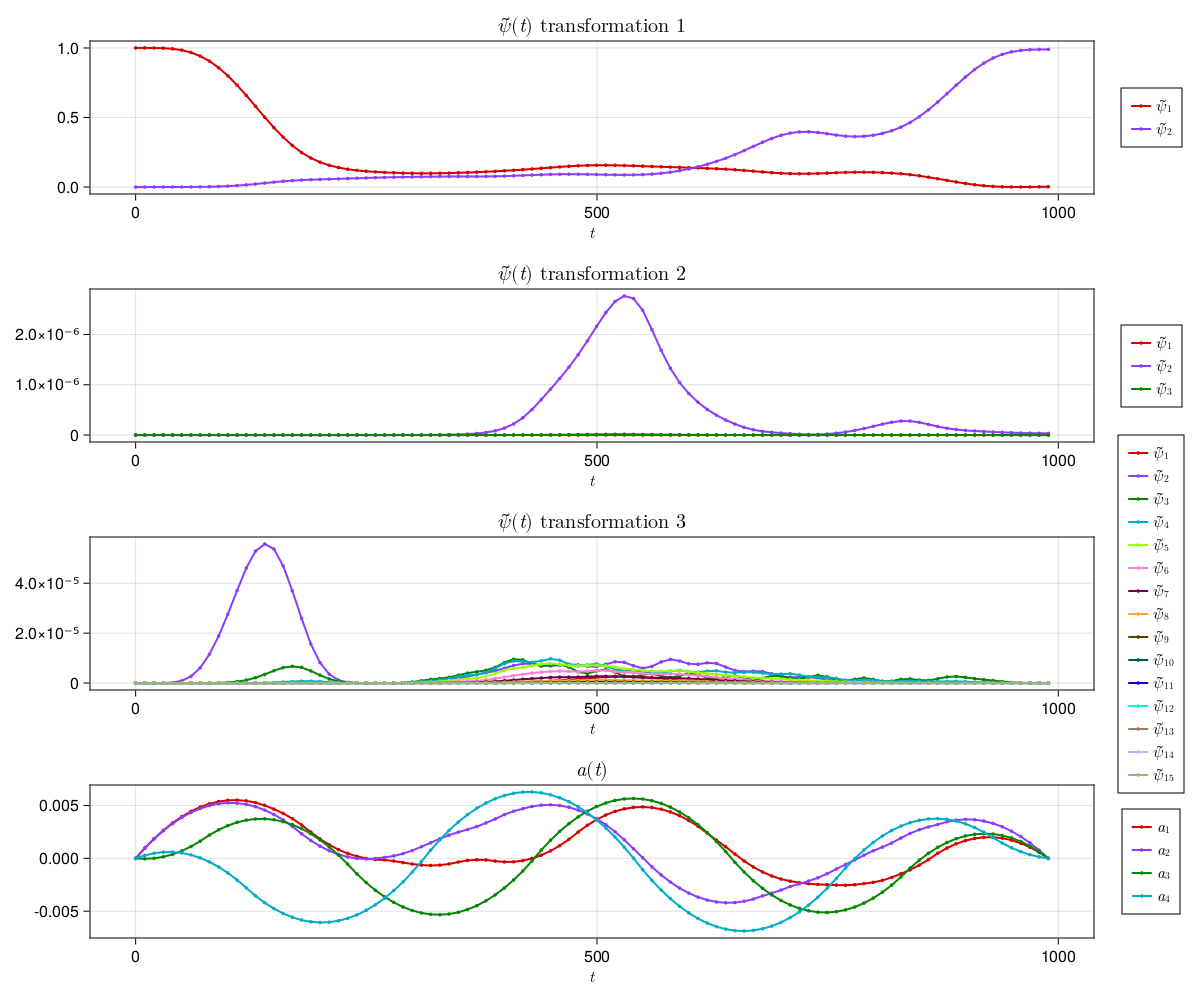

In [160]:
plot_components(
    traj, 
    [:a]; 
    transformations=transformations, 
    res=(1200, 1000),
    titlesize=20,
    ignored_labels=:ψ̃
)